In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [3]:
# Load the dataset
file_path = "../generate_data/label_embeddings.csv"
df = pd.read_csv(file_path)
labels = df['Label'].values
embeddings = df.drop(columns=['Label']).values
print(f"Label: {len(labels)}, embeddings with shape: {embeddings.shape}." )

Label: 854, embeddings with shape: (854, 100).


In [4]:
# 定义 FCM 聚类算法，并绘制SSE图，根据SSE图选择最优的聚类数
def fuzzy_c_means(X, n_clusters, m=2, max_iter=100, tol=1e-5):
    n_samples, n_features = X.shape
    # 初始化隶属度矩阵
    U = np.random.rand(n_samples, n_clusters)
    U = U / np.sum(U, axis=1, keepdims=True)

    # 初始化质心矩阵
    centroids = np.zeros((n_clusters, n_features))

    for i in range(max_iter):
        # 更新质心
        for j in range(n_clusters):
            num = np.sum((U[:, j] ** m)[:, np.newaxis] * X, axis=0)
            denom = np.sum(U[:, j] ** m)
            centroids[j] = num / denom

        # 更新隶属度矩阵
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        U_new = 1 / (distances ** (2 / (m - 1)))
        U_new /= np.sum(U_new, axis=1, keepdims=True)

        # 检查收敛性
        if np.linalg.norm(U_new - U) < tol:
            break
        U = U_new

    return centroids, U

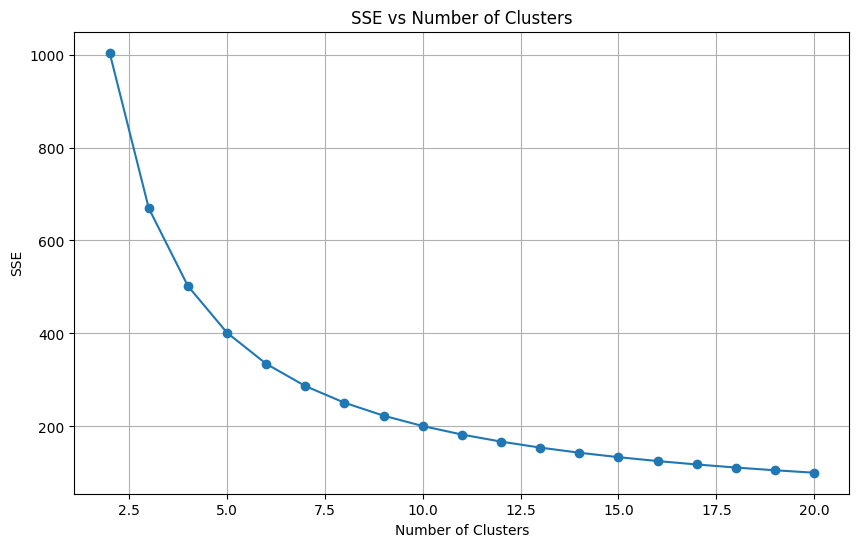

In [5]:
# 计算不同聚类数下的SEE，并绘制SSE图
def calculate_sse(X, n_clusters_range):
    sse = []
    for n_clusters in n_clusters_range:
        centroids, U = fuzzy_c_means(X, n_clusters)
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        sse.append(np.sum((U ** 2) * distances))
    return sse

# 计算不同聚类数下的SEE，并绘制SSE图
n_clusters_range = range(2, 21)
sse = calculate_sse(embeddings, n_clusters_range)
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, sse, marker='o')
plt.title('SSE vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.grid()
plt.show()

In [6]:
# 选择最优的聚类数
optimal_n_clusters = np.argmax(sse) + 2  # +2 because range starts from 2
print(f"Optimal number of clusters: {optimal_n_clusters}")

Optimal number of clusters: 2


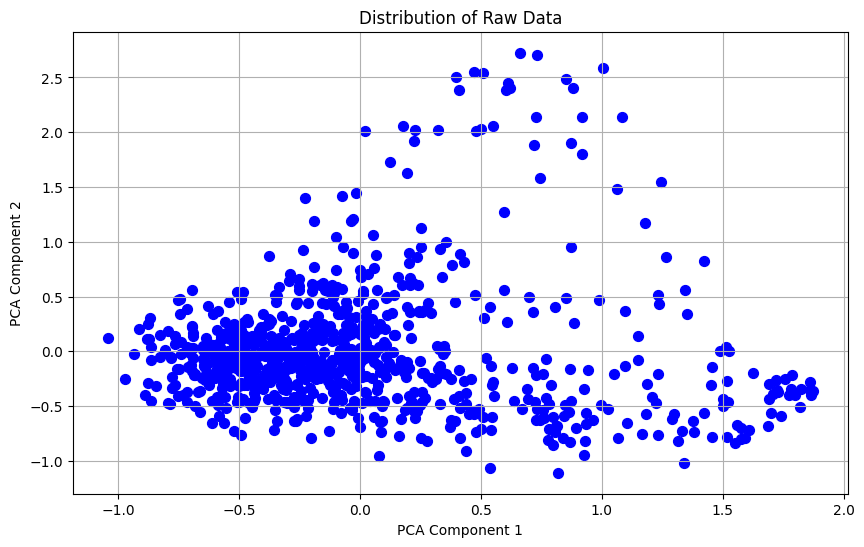

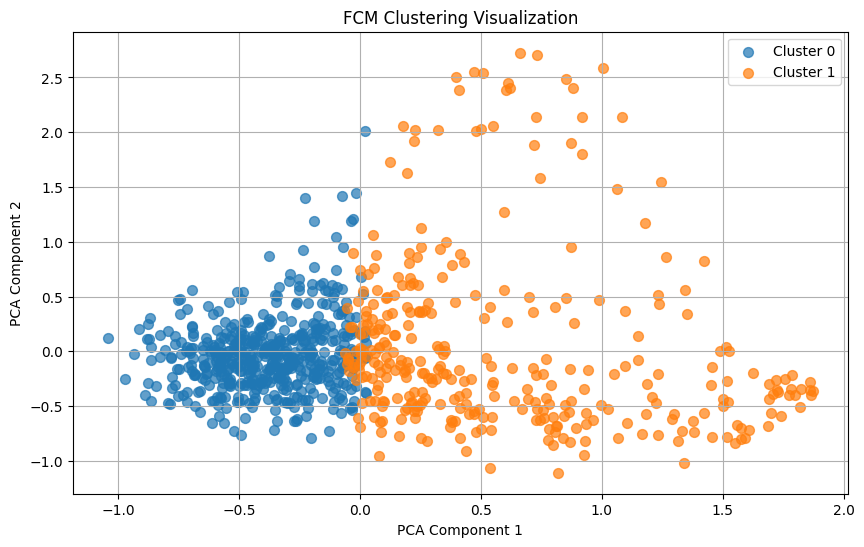

In [8]:
# 使用最佳聚类数进行 FCM 聚类
centroids, U = fuzzy_c_means(embeddings, optimal_n_clusters)
# 计算每个样本的聚类标签
labels = np.argmax(U, axis=1)

# 绘制散点图
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(embeddings)
reduced_centers = pca.fit_transform(centroids)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c='blue', s=50)
plt.title("Distribution of Raw Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for cluster_id in np.unique(labels):
    cluster_points = reduced_features[labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", s=50, alpha=0.7)
# plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1], c='red', marker='x', s=200, label="Centroids")
plt.title("FCM Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# 创建包含标签名称和对应聚类标签的DataFrame
df_labels = pd.DataFrame({'Label': df['Label'], 'Cluster': labels})
# 保存结果到CSV文件
output_file_path = "generate_data/label_embeddings_fcm.csv"
df_labels.to_csv(output_file_path, index=False)
print(f"Results saved to {output_file_path}")


Results saved to generate_data/label_embeddings_fcm.csv
